# POEMS samples
1 Logistic PCA
2 NMF results
3 Survival Analysis
4 Age BMPC% VEGF
5 Drug Response

In [1]:
library(dplyr)
library(Seurat)
library(patchwork)
library(ggplot2)
library(cowplot)
library(survival)
library(survminer)
library(openxlsx)
library(ggpubr)
library(RColorBrewer)
library("rARPACK")
library("logisticPCA")
source('survplotPCD.R')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject


Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots


Loading required package: ggpubr


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend




In [2]:
POEMSgroups<-read.xlsx('Table S5-re.xlsx', sheet = 1, startRow = 1, colNames = TRUE, rowNames = FALSE)
rownames(POEMSgroups)<-POEMSgroups$newID

In [3]:
meta<-read.csv('PCDalllist-wxz0513.csv',header=T)
rownames(meta)<-meta$newID
metaPOEMS<-meta[which(meta$diagnosis=='POEMS'),]

In [4]:
all<-read.csv('0429-snp-allmut-together-bi.csv')
rownames(all)<-all$X
all$X<-NULL
all<-all[,metaPOEMS$newID]
all<-all[which(rowSums(all)>0.02*67),]

In [5]:
normal <- CreateSeuratObject(counts =all, project = "normal",min.cells = 1)

In [6]:
normal@meta.data<-cbind(normal@meta.data,metaPOEMS[rownames(normal@meta.data),])
normal@meta.data<-cbind(normal@meta.data,POEMSgroups[rownames(normal@meta.data),])

In [7]:
suppressMessages(normal <- ScaleData(normal, features = rownames(all)))
suppressMessages(normal <- RunPCA(normal, features = rownames(all),npcs = 2))

Warning message in print.DimReduc(x = reduction.data, dims = ndims.print, nfeatures = nfeatures.print):
“Only 2 dimensions have been computed.”
Warning message:
“Requested number is larger than the number of available items (31). Setting to 31.”
Warning message:
“Requested number is larger than the number of available items (31). Setting to 31.”


In [8]:
set.seed(42)
X.df <- as.data.frame(t(all))
X <- as.matrix(sapply(X.df, as.numeric))
# Determine m via logisticSVD
logsvd_model = logisticSVD(X, k = 2)
logpca_cv = cv.lpca(X, ks = 2, ms = 1:10)
#write.table(logpca_cv, file.path(args$outdir, "logistic_pca_cv_nll.tsv") ,sep='\t')

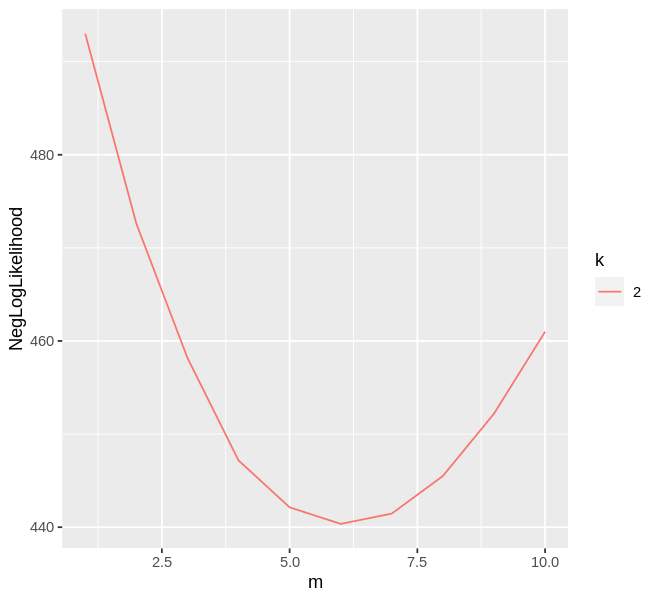

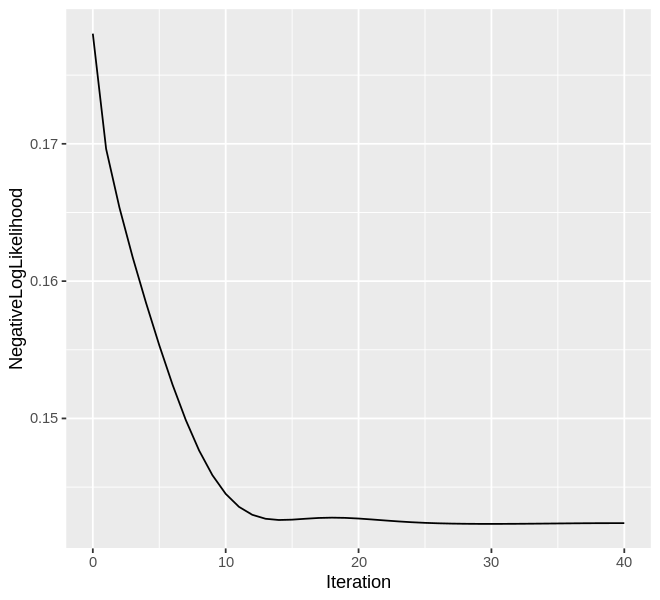

In [9]:
options(repr.plot.height=5,repr.plot.width=5.5)
# Run logistic PCA models (we  use logPCA, not convexLogisticPCA)
logpca_model = logisticPCA(X, k = 2, m = which.min(logpca_cv))
clogpca_model = convexLogisticPCA(X, k = 2, m = which.min(logpca_cv))
plot(logpca_cv)
plot(clogpca_model, type = "trace")

In [10]:
# Write out Results for PCA Loadings & PCA Components
logpca_modelPCs<-as.data.frame(logpca_model$PCs)
rownames(logpca_modelPCs) <- rownames(X.df)
colnames(logpca_modelPCs) <- c('PC_1','PC_2')
normal@reductions$pca@cell.embeddings<-as.matrix(logpca_modelPCs[rownames(normal@meta.data),])
normal@meta.data$center<-substring(normal@meta.data$ID,1,5)

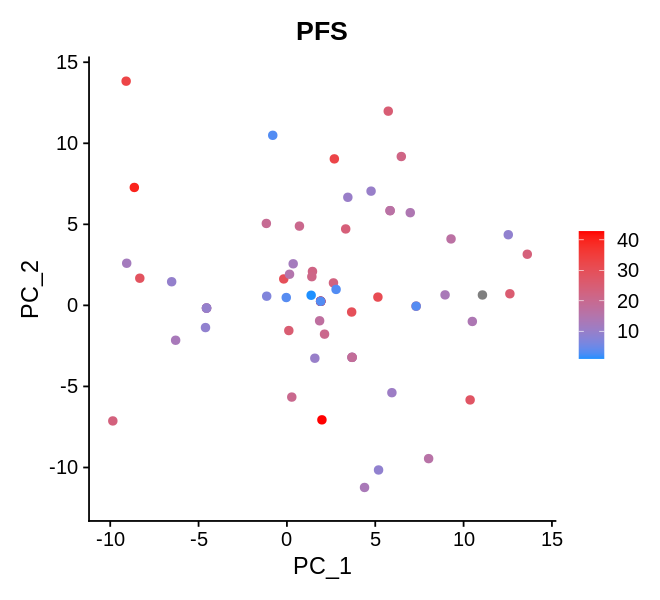

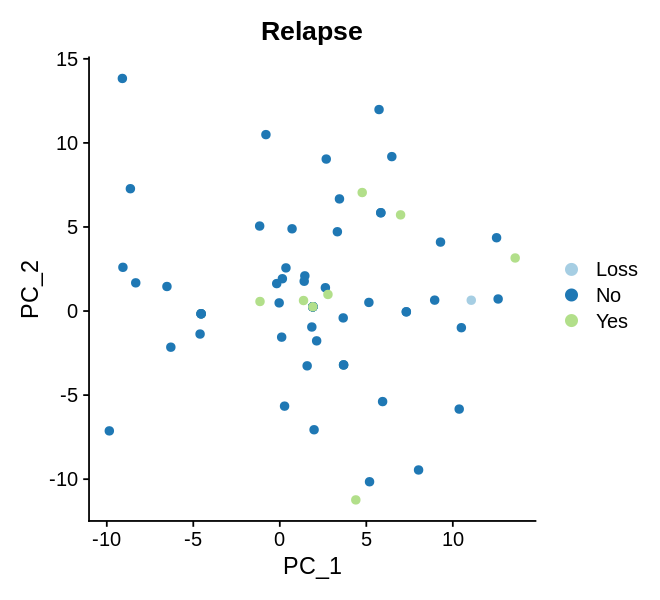

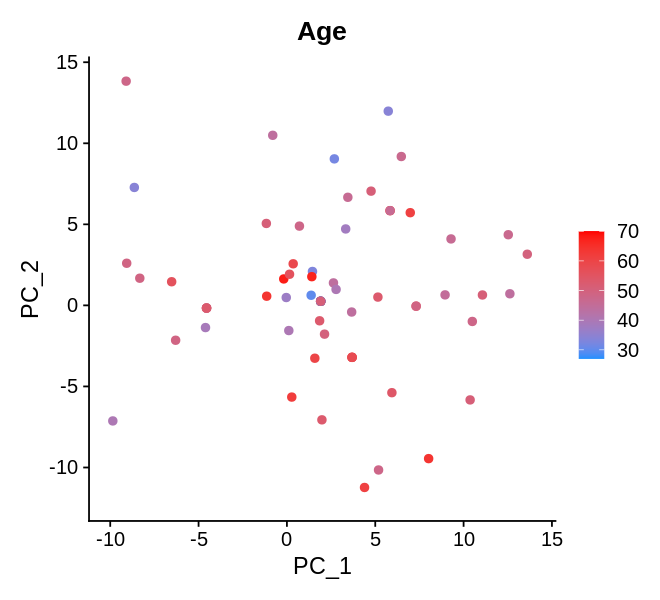

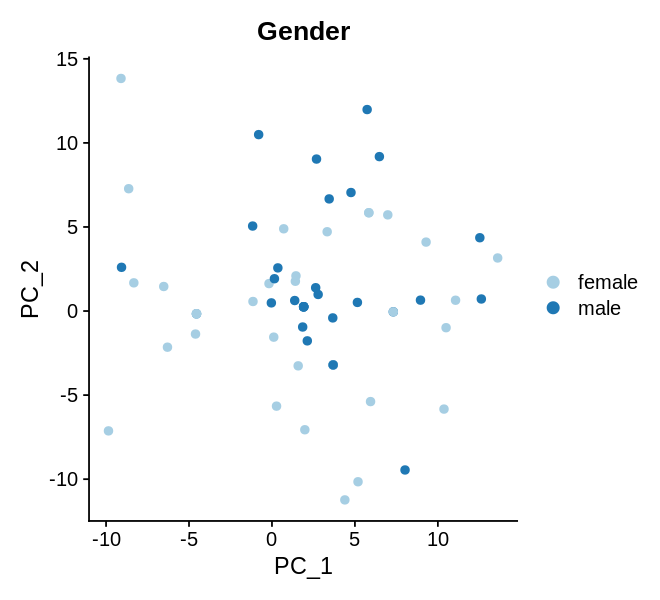

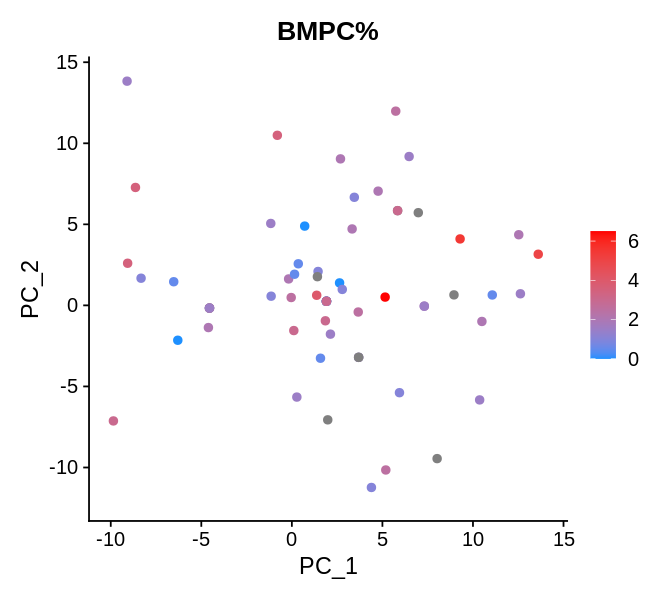

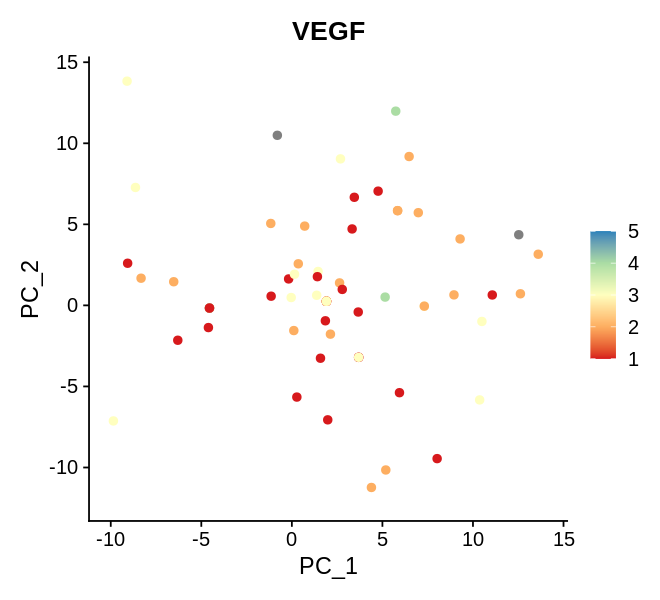

In [11]:
options(repr.plot.height=5,repr.plot.width=5.5)
FeaturePlot(normal,reduction='pca',feature='PFS',cols=c('dodgerblue','red'),pt.size=2)
DimPlot(normal, reduction = "pca",group.by='Relapse',label=F,pt.size=2,cols=brewer.pal(3,"Paired"))
FeaturePlot(normal,reduction='pca',feature='Age',cols=c('dodgerblue','red'),pt.size=2)
DimPlot(normal, reduction = "pca",group.by='Gender',label=F,pt.size=2,cols=brewer.pal(3,"Paired"))
FeaturePlot(normal,reduction='pca',feature='BMPC%',cols=c('dodgerblue','red'),pt.size=2)
FeaturePlot(normal,reduction='pca',feature='VEGF',cols=brewer.pal(5,"Spectral"),pt.size=2)

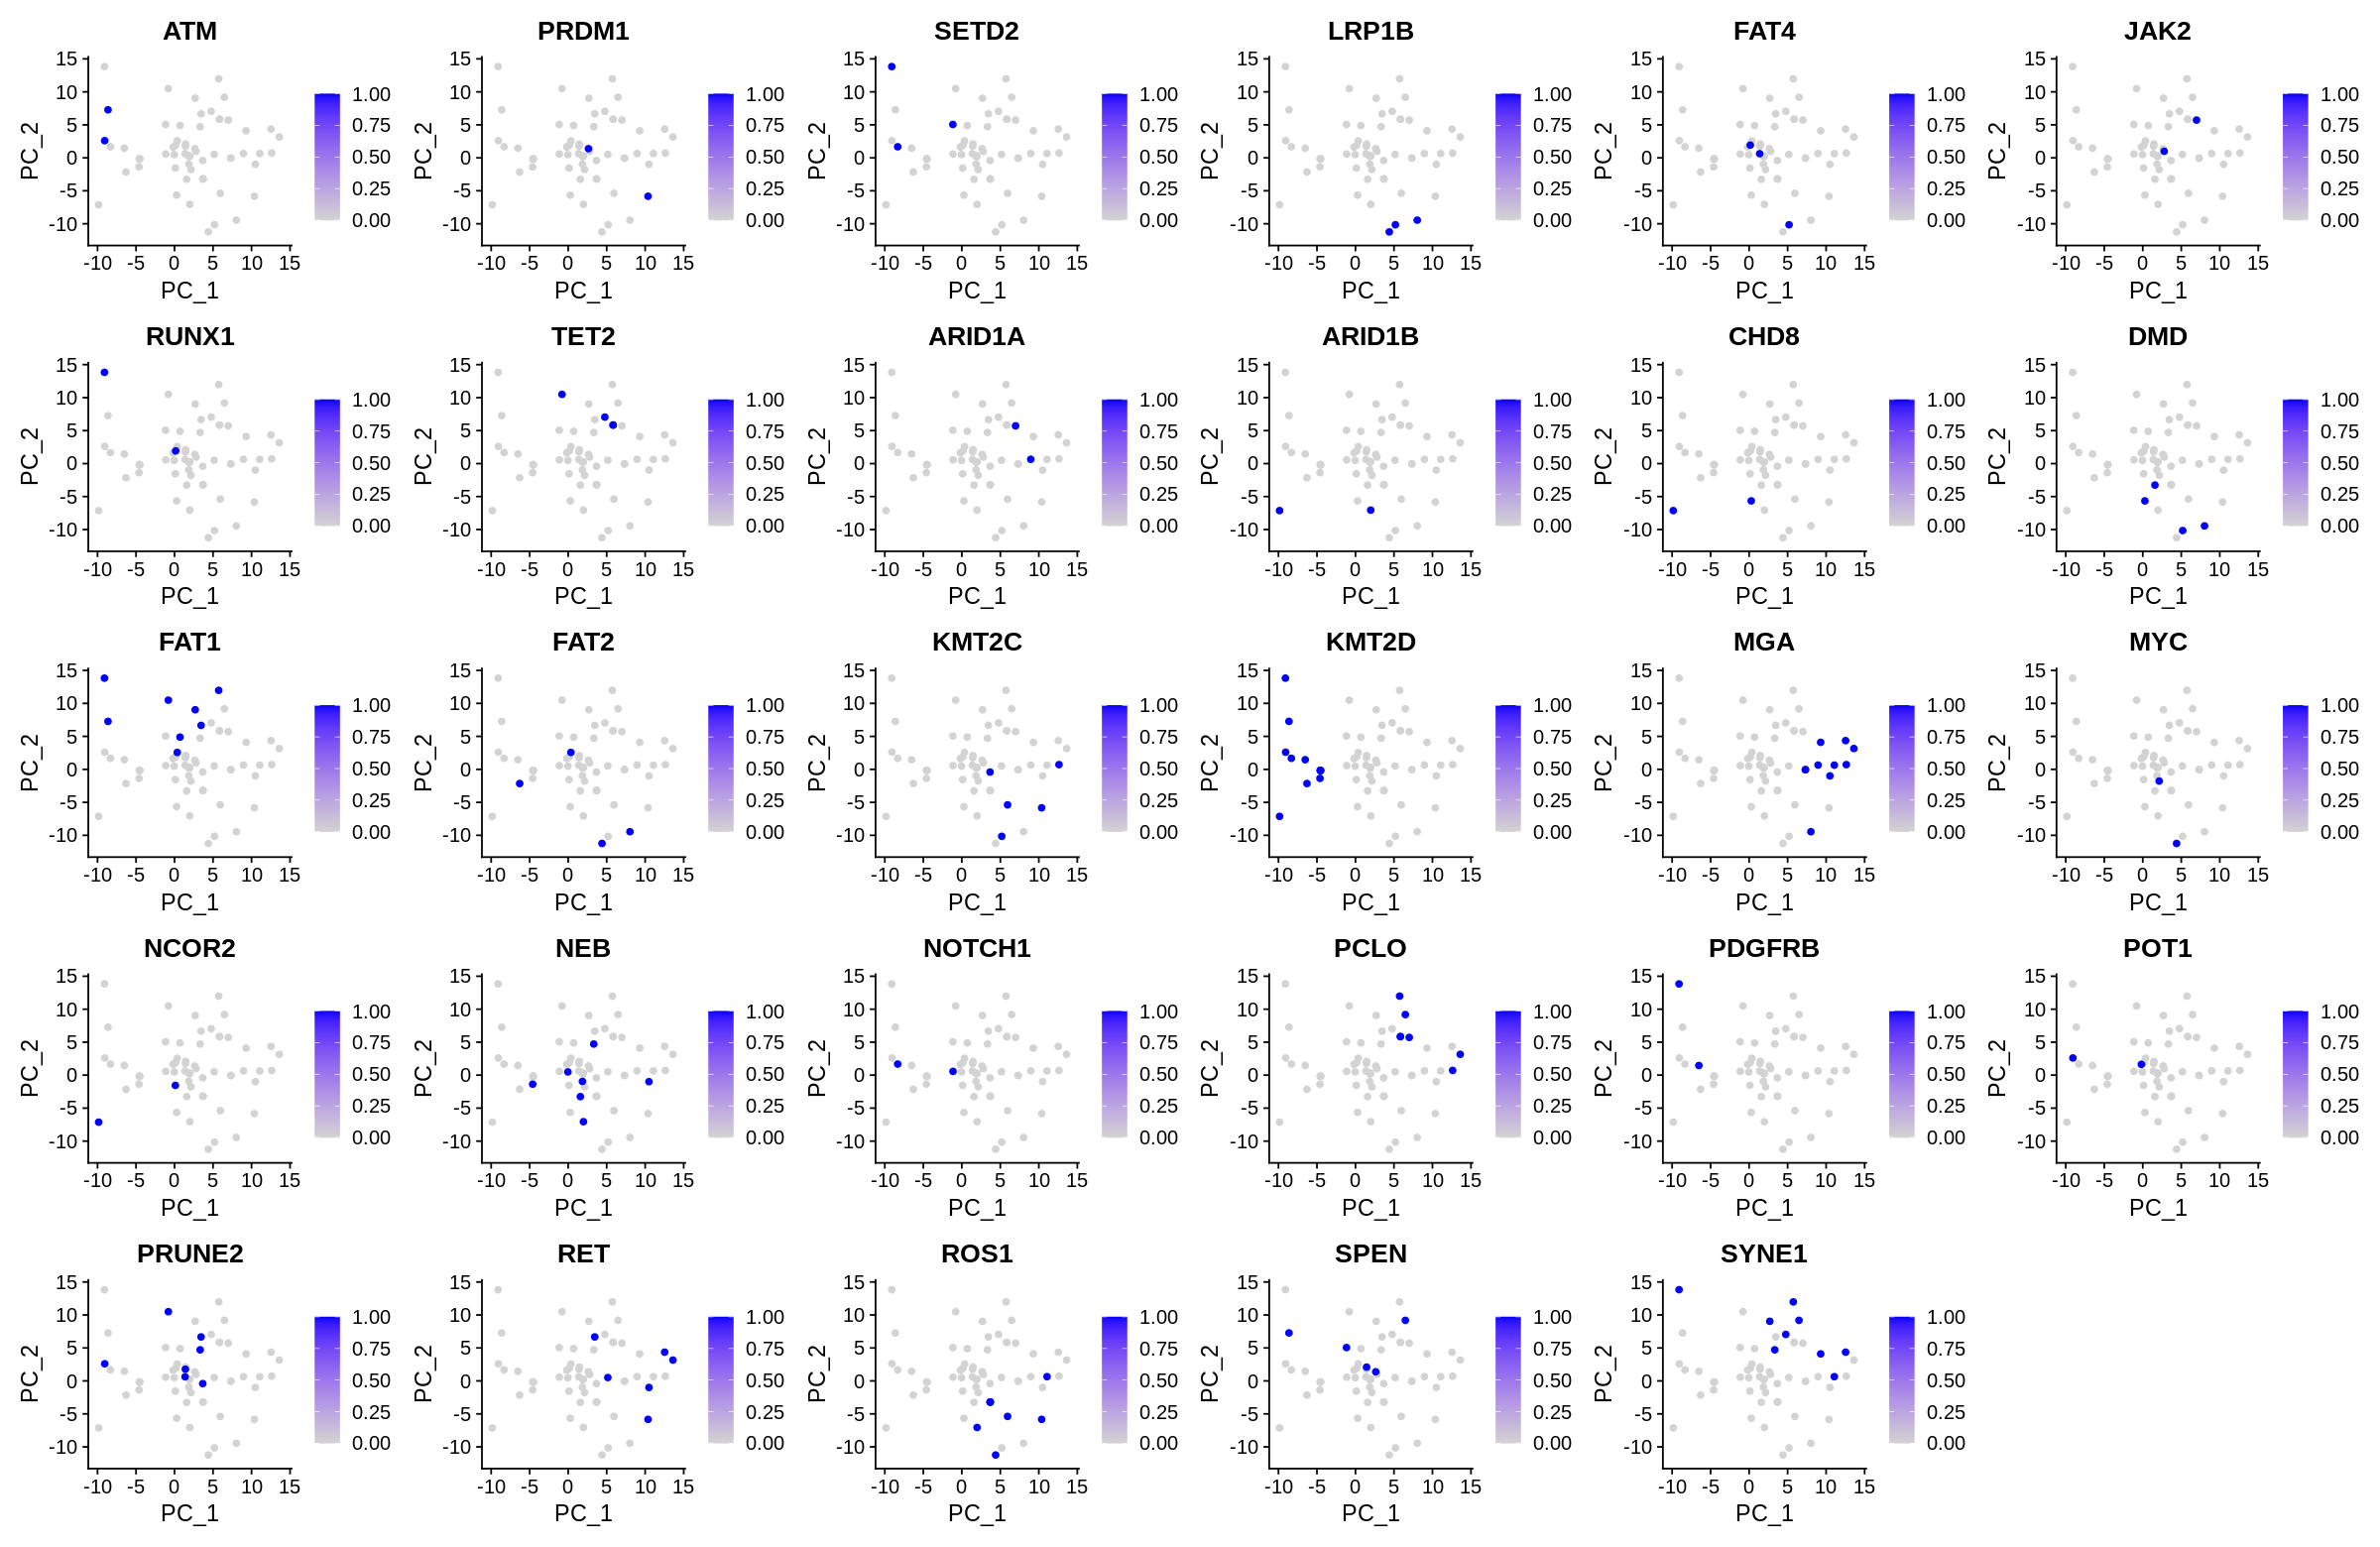

In [12]:
options(repr.plot.height=13,repr.plot.width=20)
NMCHIP<-read.csv('NMCHIP.csv',header=T)
FeaturePlot(normal, reduction = "pca",features=intersect(rownames(all),NMCHIP$Gene),label=F,pt.size=1.5,order=T,ncol=6)

In [13]:
dim(all)
write.table(as.data.frame(t(all)), file='test_POEMS_loh.tsv', quote=FALSE, sep='\t', col.names = NA)

[1] 31 67

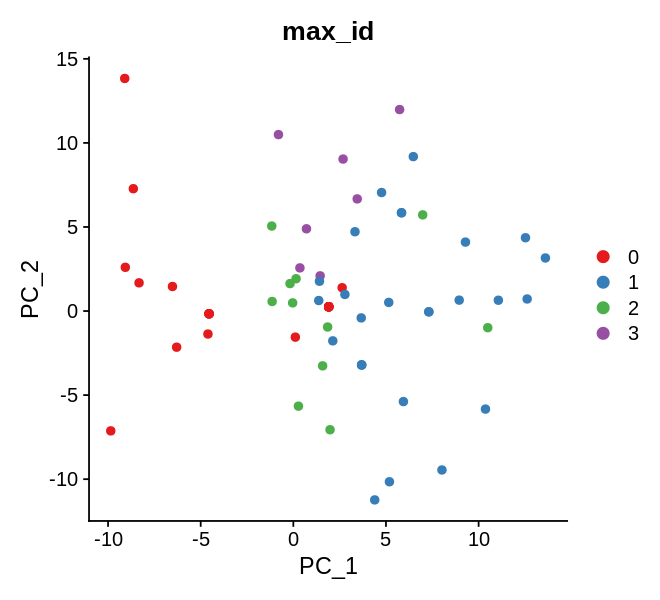

In [14]:
nmf<-read.delim( "./downsampling/H_bnmf_k6_4.tsv" )
rownames(nmf)<-nmf$X
normal@meta.data<-cbind(normal@meta.data,nmf[rownames(normal@meta.data),])
options(repr.plot.height=5,repr.plot.width=5.5)
DimPlot(normal, reduction = "pca",group.by='max_id',label=F,pt.size=2,cols=brewer.pal(9,"Set1"))

In [15]:
POEMSgroups$max_id<-nmf[POEMSgroups$newID,]$max_id
table(POEMSgroups$max_id)


 0  1  2  3 
22 27 11  7 

Warning message in survplotPCD(data = POEMSgroups, status = "Relapse", time = "PFS", :
“NAs introduced by coercion”


png 
  2

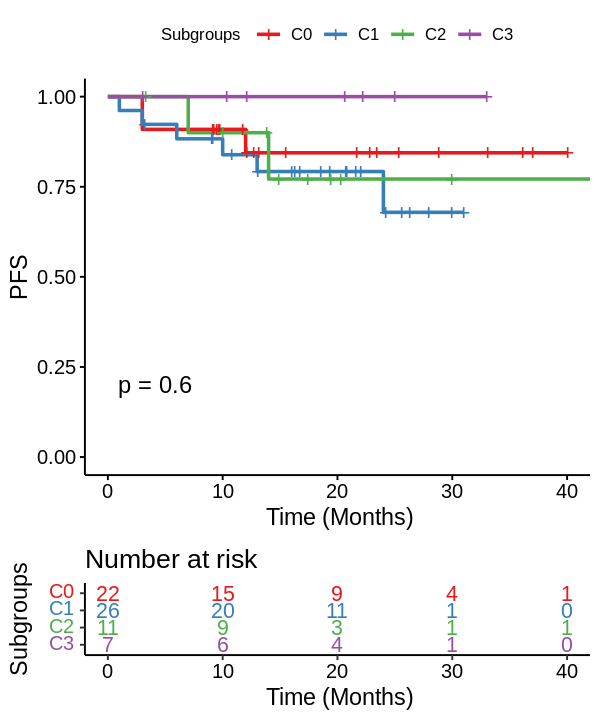

In [16]:
suppressMessages(p<-survplotPCD(data=POEMSgroups,status='Relapse',
                             time='PFS',negative='No',positive='Yes',
                                           group='max_id',labels=c("C0",'C1',"C2",'C3')))
p
pdf(file="POEMS.pdf",height=6,width=5)
p
dev.off()

In [17]:
POEMSgroups$max<-POEMSgroups$'max_id'
POEMSgroups$max<-gsub('0','others',POEMSgroups$max)
POEMSgroups$max<-gsub('2','others',POEMSgroups$max)
POEMSgroups$max<-gsub('3','others',POEMSgroups$max)

Warning message in survplotPCD(data = POEMSgroups, status = "Relapse", time = "PFS", :
“NAs introduced by coercion”


png 
  2

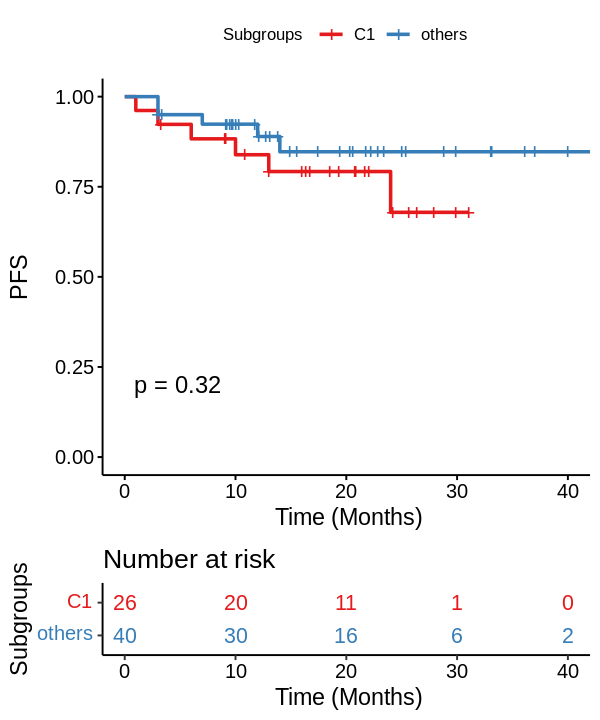

In [18]:
suppressMessages(p<-survplotPCD(data=POEMSgroups,status='Relapse',
                             time='PFS',negative='No',positive='Yes',
                                           group='max',labels=c('C1',"others")))
p
pdf(file="POEMSother1.pdf",height=6,width=5)
p
dev.off()

In [19]:
POEMSgroups$max<-POEMSgroups$'max_id'
POEMSgroups$max<-gsub('0','others',POEMSgroups$max)
POEMSgroups$max<-gsub('2','others',POEMSgroups$max)
POEMSgroups$max<-gsub('1','others',POEMSgroups$max)

Warning message in survplotPCD(data = POEMSgroups, status = "Relapse", time = "PFS", :
“NAs introduced by coercion”


png 
  2

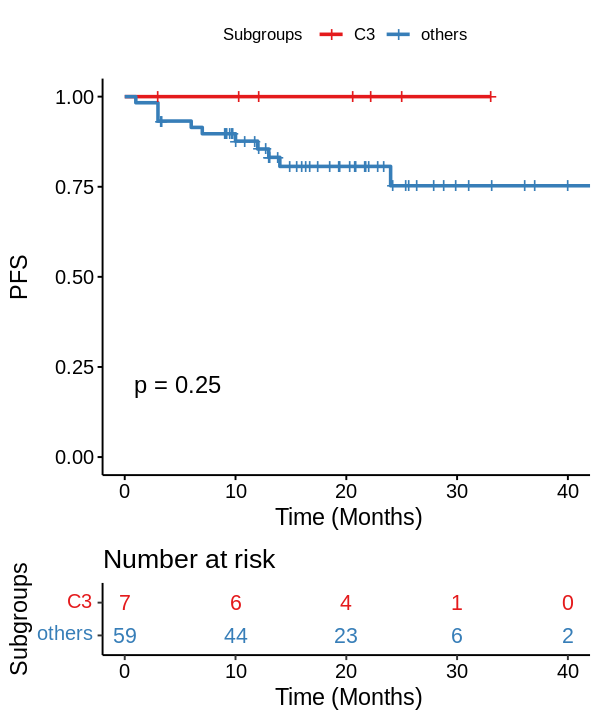

In [20]:
suppressMessages(p<-survplotPCD(data=POEMSgroups,status='Relapse',
                             time='PFS',negative='No',positive='Yes',
                                           group='max',labels=c('C3',"others")))
p
pdf(file="POEMSother2.pdf",height=6,width=5)
p
dev.off()

Warning message in wilcox.test.default(c(58, 51, 48, 49, 49, 34, 40, 40, 51, 68, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(58, 51, 48, 49, 49, 34, 40, 40, 51, 68, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(58, 51, 48, 49, 49, 34, 40, 40, 51, 68, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(54, 40, 30, 50, 51, 46, 54, 51, 51, 47, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(54, 40, 30, 50, 51, 46, 54, 51, 51, 47, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(53, 61, 53, 64, 62, 51, 56, 48, 60, 37, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(58, 51, 48, 49, 49, 34, 40, 40, 51, 68, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(58, 51, 48, 49, 49, 34, 40, 40, 51, 68, :
“cannot compute exact p-value with ties”
Warning 

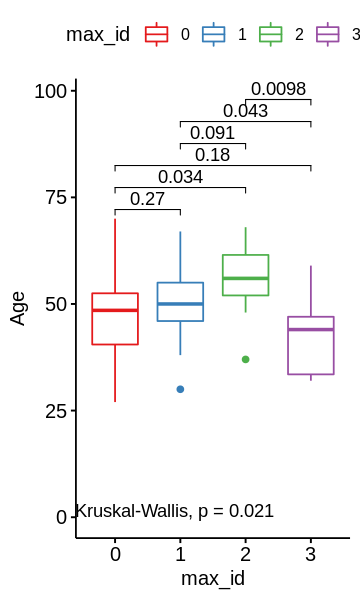

In [21]:
options(repr.plot.height=5,repr.plot.width=3)
ggboxplot(POEMSgroups, x="max_id", y="Age", color = "max_id")+
  stat_compare_means(label.y = 0)+
 scale_color_brewer(palette='Set1')+
stat_compare_means(comparisons = list( c("0", "1") , c("0", "2"),c("0", "3"),c("1", "2") , c("1", "3"),c("2", "3")))
ggsave(filename="POEMS1.pdf",height=5,width=3)

Warning message:
“Removed 11 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 11 rows containing non-finite values (stat_compare_means).”
Warning message:
“Removed 11 rows containing non-finite values (stat_signif).”
Warning message in wilcox.test.default(c(0.5, 3, 1.5, 0, 1, 3.5, 3, 3, NA, NA, 1.5, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.5, 3, 1.5, 0, 1, 3.5, 3, 3, NA, NA, 1.5, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(0.5, 3, 1.5, 0, 1, 3.5, 3, 3, NA, NA, 1.5, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(NA, 1, 4, 5, 2, 5.5, 1, 1.5, 0.5, 1.5, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(NA, 1, 4, 5, 2, 5.5, 1, 1.5, 0.5, 1.5, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(NA, NA, 3, 1, 1.5, 1.5, 0.5, 2, 0.5, 2.5, :
“cannot compute exact p-value with ties”
Wa

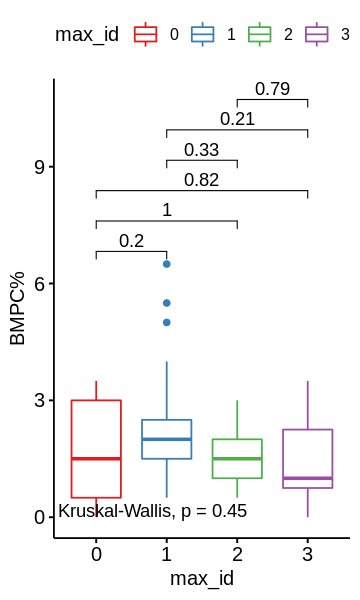

In [22]:
ggboxplot(POEMSgroups, x="max_id", y="BMPC%", color = "max_id")+
  stat_compare_means(label.y = 0)+
 scale_color_brewer(palette='Set1')+
stat_compare_means(comparisons = list( c("0", "1") , c("0", "2"),c("0", "3"),c("1", "2") , c("1", "3"),c("2", "3")))
ggsave(filename="POEMS2.pdf",height=5,width=3)

Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2 rows containing non-finite values (stat_compare_means).”
Warning message:
“Removed 2 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2 rows containing non-finite values (stat_compare_means).”
Warning message:
“Removed 2 rows containing non-finite values (stat_signif).”


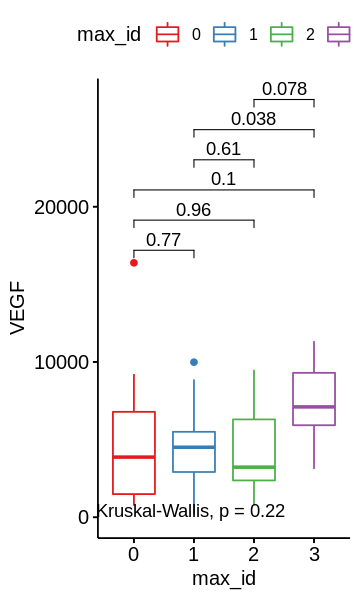

In [23]:
ggboxplot(POEMSgroups, x="max_id", y="VEGF", color = "max_id")+
  stat_compare_means(label.y = 0)+
 scale_color_brewer(palette='Set1')+
stat_compare_means(comparisons = list( c("0", "1") , c("0", "2"),c("0", "3"),c("1", "2") , c("1", "3"),c("2", "3")))
ggsave(filename="POEMS3.pdf",height=5,width=3)

In [24]:
table(POEMSgroups$Therapy.1st)


ASCT(RD induction)                 BD               Ldex                 MD 
                 1                 23                 37                  2 
                RD                TCD 
                 1                  1 

In [25]:
POEMSgroupsBD<-POEMSgroups[which(POEMSgroups$Therapy.1st=='Ldex'),]
as.data.frame(table(POEMSgroupsBD[,c('Relapse','max_id')]))

Relapse,max_id,Freq
<fct>,<fct>,<int>
No,0,12
Yes,0,1
No,1,13
Yes,1,0
No,2,6
Yes,2,1
No,3,4
Yes,3,0


In [26]:
POEMSgroupsLD<-POEMSgroups[which(POEMSgroups$Therapy.1st=='Ldex'),]
as.data.frame(table(POEMSgroupsLD[,c('Relapse','max_id')]))

Relapse,max_id,Freq
<fct>,<fct>,<int>
No,0,12
Yes,0,1
No,1,13
Yes,1,0
No,2,6
Yes,2,1
No,3,4
Yes,3,0
